## Load Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, random
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, Input, BatchNormalization
from keras import regularizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model

## Data Preparation

### Load Dataset

In [2]:
data = pd.read_csv('../datasets/fer2013.csv')
data.shape

(35887, 3)

### Data Exploration

In [3]:
data.head(3)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training


In [4]:
print(data.isnull().mean()*100)

emotion    0.0
pixels     0.0
Usage      0.0
dtype: float64


### Data Visualization

In [5]:
CLASSES_LIST = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']
CLASSES_DICT = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}

In [6]:
fig = px.bar(
    x = CLASSES_LIST,
    y = [list(data['emotion']).count(i) for i in np.unique(data['emotion'])],
    color = np.unique(data['emotion']),
    color_continuous_scale="Emrld"
)
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    })
fig.write_image("../results/visualizations/data_distribution.png", width=3.5*300, height=2*300, scale=4) 
fig.show()

## Data Preprocessing

In [7]:
# Shuffling
data = data.sample(frac=1)

### One Hot Encoding

In [8]:
labels = to_categorical(data[['emotion']], num_classes=7)

features = data['pixels'].astype(str).str.split(' ').tolist()
features = np.uint8(features)

### Standardization

In [9]:
X = features.reshape((35887*2304,1))

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape
X = X.reshape((35887, 48, 48,1))

### Train-Test-Val Split

In [10]:
# Training - 80%
# Test - 10%
# Validation - 10%
X_train, X_temp, y_train, y_temp = train_test_split(X, labels, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Data Augmentation

In [11]:
data_gen = ImageDataGenerator(
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    zoom_range = 0.2
)
val_gen = ImageDataGenerator(
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    zoom_range = 0.2
)

In [12]:
data_gen.fit(X_train)
val_gen.fit(X_val)

train_gen = data_gen.flow(X_train, y_train, batch_size=64)
val_gen = data_gen.flow(X_val, y_val, batch_size=64)

## Model Training

### Building CNN Model

In [13]:
def model_cnn():
    
    model = Sequential()

    # 1st Batch
    model.add(Input(shape=(48, 48, 1)))
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # 2nd Batch
    model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # 3rd Batch
    model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # 4th Batch
    model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # 5th Batch
    model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # 6th Batch
    model.add(Flatten()) 
    model.add(Dense(256,activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # 7th Batch
    model.add(Dense(512,activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # 8th Batch
    model.add(Dense(7, activation='softmax'))
    model.compile(
        optimizer = Adam(learning_rate=0.0001), 
        loss='categorical_crossentropy', 
        metrics=['accuracy'])
    
    return model

model = model_cnn()

### Compile Model

In [14]:
model.compile(
    optimizer = Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 3, 3, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,810,183 (22.16 MB)

 Trainable params: 5,805,191 (22.15 MB)

 Non-trainable params: 4,992 (19.50 KB)

In [15]:
# Early Stopping

checkpointers = [
    EarlyStopping(monitor = 'val_accuracy',
                  verbose = 1,
                  restore_best_weights = True,
                  mode = "max",
                  patience = 5),
    ModelCheckpoint('../results/models/best_model.keras',
                    monitor = "val_accuracy",
                    verbose = 1,
                    save_best_only = True,
                    mode = "max")
]

In [17]:
history = model.fit(train_gen,
                    epochs=10,
                    batch_size=64,   
                    verbose=1,
                    callbacks=[checkpointers],
                    validation_data=val_gen)

Epoch 1/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 796ms/step - accuracy: 0.1664 - loss: 14.5993
Epoch 1: val_accuracy improved from -inf to 0.21928, saving model to ../results/models/best_model.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 371s 821ms/step - accuracy: 0.1665 - loss: 14.5983 - val_accuracy: 0.2193 - val_loss: 13.1108
Epoch 2/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 793ms/step - accuracy: 0.2048 - loss: 12.8355
Epoch 2: val_accuracy improved from 0.21928 to 0.26219, saving model to ../results/models/best_model.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 366s 816ms/step - accuracy: 0.2048 - loss: 12.8345 - val_accuracy: 0.2622 - val_loss: 11.3119
Epoch 3/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 835ms/step - accuracy: 0.2272 - loss: 11.0303
Epoch 3: val_accuracy improved from 0.26219 to 0.27640, saving model to ../results/models/best_model.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 386s 859ms/step - accuracy: 0.2272 - loss: 11.0293 - val_accuracy: 0.2764 - val_loss: 9.5112
Epoch 4/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 899m

In [18]:
y_pred = np.argmax((model.predict(X_test)), axis=1)

print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step
              precision    recall  f1-score   support

           0      0.371     0.340     0.355       482
           1      1.000     0.036     0.070        55
           2      0.297     0.254     0.274       508
           3      0.687     0.796     0.738       899
           4      0.368     0.415     0.390       603
           5      0.646     0.573     0.607       417
           6      0.447     0.443     0.445       625

    accuracy                          0.495      3589
   macro avg      0.545     0.408     0.411      3589
weighted avg      0.494     0.495     0.486      3589



## Visualizations

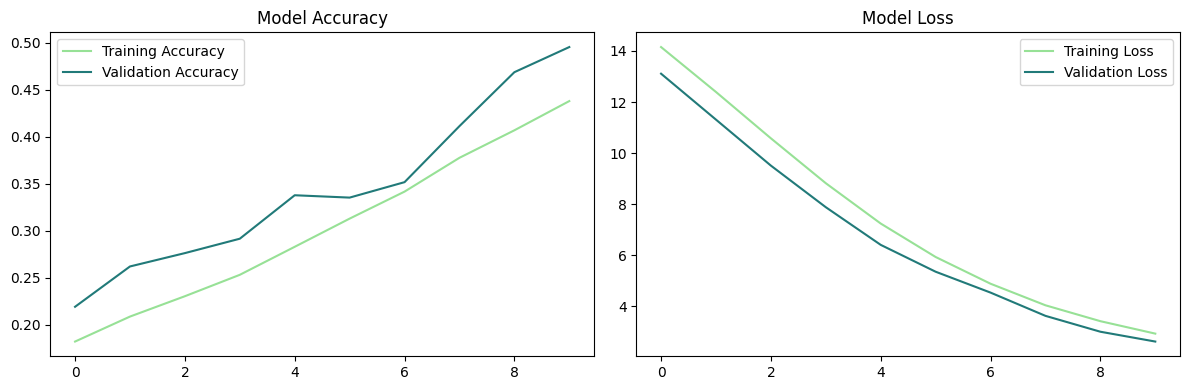

In [25]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

sns.lineplot(x=range(len(history.history['accuracy'])), y=history.history['accuracy'], color='#97e196', label='Training Accuracy', ax=ax[0])
sns.lineplot(x=range(len(history.history['val_accuracy'])), y=history.history['val_accuracy'], color='#217a79', label='Validation Accuracy', ax=ax[0])
ax[0].set_title('Model Accuracy')
ax[0].legend()

sns.lineplot(x=range(len(history.history['loss'])), y=history.history['loss'], color='#97e196', label='Training Loss', ax=ax[1])
sns.lineplot(x=range(len(history.history['val_loss'])), y=history.history['val_loss'], color='#217a79', label='Validation Loss', ax=ax[1])
ax[1].set_title('Model Loss')
ax[1].legend()

plt.tight_layout()
plt.savefig('../results/visualizations/model_accuracy_loss.png', dpi=200)
plt.show()